In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
from pycaret.classification import *

import sys
sys.path.append('../../../scripts/')
from PreparaDataset import *

# Parâmetros do método

In [2]:
TARGET = 'Back_Over'
ODDS = 'Odds_Over'

# Carregando o dataset

In [3]:
data = pd.read_excel('../../base_basquete.xlsx')

In [4]:
def prepara_dataset(_df):
    # Limpa _df
    _df.replace([np.inf, -np.inf], 0, inplace=True)
    _df.dropna(subset=['Avg_CG_H', 'Avg_CG_A', TARGET], inplace=True)

    _df.reset_index(drop=True, inplace=True)

    return _df

In [5]:
df = prepara_dataset(data)

In [6]:
TRAIN_SIZE = 0.625

div = int(TRAIN_SIZE * len(df))
treino = df.iloc[:div, :]
val = df.iloc[div: , :]

print(f'Treino: {treino.shape[0]} | Validação: {val.shape[0]}')
print(f"Odd média: {treino[ODDS].mean():.2f}")
print(f"WR: {treino[TARGET].mean():.2f} (Odd justa: {1 / treino[TARGET].mean():.2f})")

Treino: 3163 | Validação: 1898
Odd média: 1.90
WR: 0.54 (Odd justa: 1.86)


# Validação 2

In [7]:
VAL2_SIZE = 0.5

div = int(VAL2_SIZE * len(val))
val1 = val.iloc[:div, :]
val2 = val.iloc[div: , :]

print(f'Validação 1: {val1.shape[0]} | Validação 2: {val2.shape[0]}')

Validação 1: 949 | Validação 2: 949


# Criação do modelo

In [8]:
features = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Porc_Over_Home',
       'Porc_Over_Away', 'Avg_CG_H', 'DP_CG_H',
       'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'MediaCustoGolHome',
       'MediaCustoGolAway', 'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H',
       'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML',
       'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH', 'Custo_Retorno_BH',
       'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real', 'Dist_Porc_BH',
       'Retornos_BA_Acu', 'Avg_Retornos_BA', 'Custo_Retorno_BA',
       'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real', 'Dist_Porc_BA', ODDS]

features = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line',  'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 
       'P(O)', 'P(U)', 'P_Diff', 'CV_ML',
       'CV_Over', 'CV_HA', ODDS]

In [9]:
def cria_setup(seed = 2023, features = features):
    cls = setup(data = treino,
            ignore_features = [x for x in treino.columns.to_list() if x not in features and x != TARGET],
            target = TARGET,
            train_size = 0.5,
            normalize = True,
            normalize_method = 'minmax',
            session_id = seed,
            remove_outliers = True,
            fix_imbalance = True,
            verbose = False
            )

In [10]:
cria_setup(seed = 2023, features = features)

xtrain_treino = get_config('X_train')
ytrain_treino = get_config('y_train')
xtrain_teste = get_config('X_test')
ytrain_teste = get_config('y_test')

real_treino = pd.concat([xtrain_treino, ytrain_treino], axis=1)
real_teste = pd.concat([xtrain_teste, ytrain_teste],  axis=1)

In [18]:
top = compare_models(exclude=['catboost', 'dummy'], fold = 5, sort='precision', n_select=14)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:47:23
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5130,0.5099,0.5194,0.5497,0.5336,0.0249,0.0249,0.0620
xgboost,Extreme Gradient Boosting,0.5136,0.5172,0.5512,0.5477,0.5488,0.0211,0.0211,0.1060
knn,K Neighbors Classifier,0.5085,0.5021,0.5382,0.5437,0.5407,0.0122,0.0122,0.8140
et,Extra Trees Classifier,0.5066,0.4982,0.5406,0.5424,0.5403,0.0076,0.0076,0.1060
rf,Random Forest Classifier,0.5010,0.5060,0.5394,0.5363,0.5372,-0.0044,-0.0044,0.1220
lightgbm,Light Gradient Boosting Machine,0.4971,0.5063,0.5382,0.5327,0.5350,-0.0125,-0.0126,0.1540
ada,Ada Boost Classifier,0.4895,0.4982,0.4642,0.5304,0.4949,-0.0166,-0.0166,0.0860
lda,Linear Discriminant Analysis,0.4889,0.4872,0.4947,0.5279,0.5097,-0.0232,-0.0232,0.0580
lr,Logistic Regression,0.4877,0.4744,0.5111,0.5238,0.5165,-0.0284,-0.0287,1.0420
ridge,Ridge Classifier,0.4864,0.0000,0.5064,0.5234,0.5137,-0.0305,-0.0306,0.0580


In [24]:
model = blend_models(estimator_list = [top[9], top[7]], fold = 5, verbose=False)

In [ ]:
tuned = tune_model(model, fold = 5, optimize = 'precision', return_train_score=True, n_iter=50)

In [28]:
ens_bag = ensemble_model(model, fold = 5, method='Bagging', verbose=False)

In [12]:
def filtra_resultados(_df, filtro = 0):
    _df = _df[_df['prediction_label'] == 1]

    if filtro == 1:
        _df = _df[((_df['Odds_A'] < 1.75) | (_df['Odds_A'] > 2.8))]
        _df = _df[((_df['Over_Line'] < 225))]
        _df = _df[((_df['P_Diff'] < 0.043) | (_df['P_Diff'] > 0.045))]
    if filtro == 2:
        _df = _df[((_df['Odds_A'] < 1.75) | (_df['Odds_A'] > 2.8))]
        _df = _df[((_df['HA_Line'] < -8.5) | (_df['HA_Line'] > -5.5))]
        _df = _df[((_df['CV_ML'] >= 0) & (_df['CV_ML'] < 0.65)) | ((_df['CV_ML'] >= 0.77) & (_df['CV_ML'] < 0.87)) | ((_df['CV_ML'] >= 0.95) & (_df['CV_ML'] < 1.5))]

    return _df

In [13]:
def calcula_profit(_df, stake = 1):
    _df.loc[(_df[TARGET] == 1), 'PL_BF_Predictions'] = (_df[ODDS] - 1) * stake
    _df.loc[(_df[TARGET] == 0), 'PL_BF_Predictions'] = - stake

    return _df

def exibe_metricas(_df, total, stake = 1, return_metrics = False):
    plb = _df['PL_BF_Predictions'].sum()
    entradas = _df.shape[0]
    wr = round((_df[_df[TARGET] == 1].shape[0] / entradas), 2)
    oddback = (_df[ODDS].mean())
    med_gain = _df[_df[TARGET] == 1]['PL_BF_Predictions'].mean()
    med_loss = _df[_df[TARGET] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

    if return_metrics == False:
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
        print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
        print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
        print(f'EM: {ev:.2f}')
        print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')
    else:
        return_metrics == True
        metrics = [plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev]
        return metrics

def exibe_grafico(_df):
    _df.sort_index(inplace=True)
    _df.reset_index(drop=True, inplace=True)
    _df['hbacu'] = _df['PL_BF_Predictions'].cumsum()
    _df['hbacu'].plot.line(figsize=(7,2))
    plt.show()

def treina_modelo(modelo, data):
    _df = predict_model(modelo, data, verbose = False)
    _df = _df.merge(df[[TARGET]], left_index=True, right_index=True, how='left')
    if f'{TARGET}_x' in _df.columns.tolist():
        _df.rename(columns={f'{TARGET}_x': TARGET}, inplace=True)
        _df.drop(columns=f'{TARGET}_y', inplace=True)
    
    return _df

def info_modelo(modelo, data, stake = 1, filtro = 0):
    total = data.shape[0]

    _df = treina_modelo(modelo, data)
    _df = filtra_resultados(_df, filtro=filtro)
    _df = calcula_profit(_df, stake)
    exibe_metricas(_df, total, stake)
    exibe_grafico(_df)
    
    return _df


PL: 33.20 | ROI: 12.34% | Prec.: 0.59
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.12
269 entradas em 1581 jogos (17.01%)


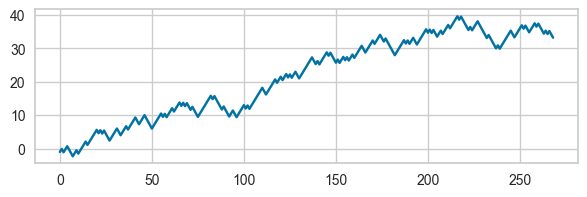

PL: 45.10 | ROI: 17.55% | Prec.: 0.62
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.18
257 entradas em 1582 jogos (16.25%)


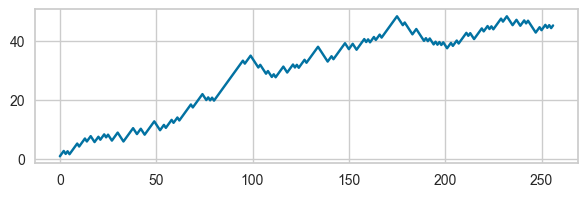

PL: 78.30 | ROI: 14.89% | Prec.: 0.60
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.14
526 entradas em 3163 jogos (16.63%)


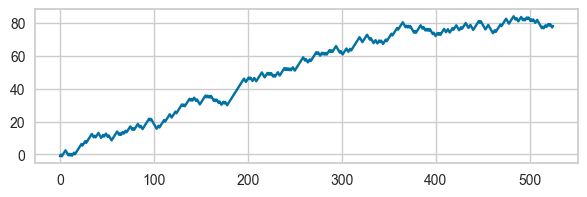

In [25]:
mdl = model
flt = 2
df_tr = info_modelo(mdl, real_treino, filtro = flt)
df_teste = info_modelo(mdl, real_teste, filtro = flt)
df_comp = info_modelo(mdl, treino, filtro = flt)

PL: 29.40 | ROI: 17.09% | Prec.: 0.62
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.18
172 entradas em 949 jogos (18.12%)


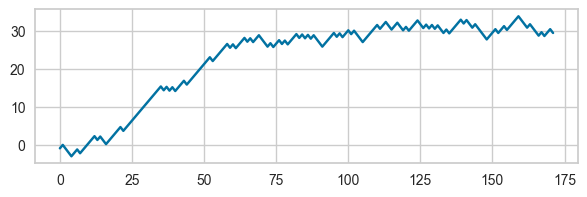

PL: 29.60 | ROI: 10.72% | Prec.: 0.58
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.11
276 entradas em 949 jogos (29.08%)


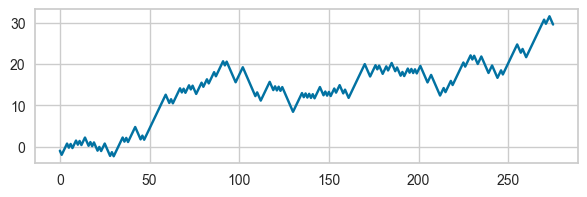

PL: 59.00 | ROI: 13.17% | Prec.: 0.59
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.12
448 entradas em 1898 jogos (23.60%)


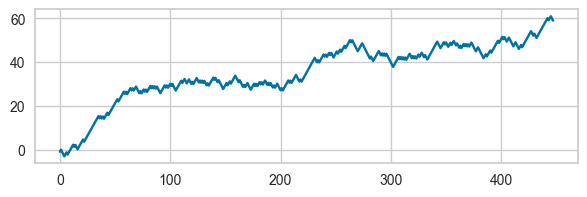

In [26]:
df_val1 = info_modelo(mdl, val1, filtro = flt)
df_val2 = info_modelo(mdl, val2, filtro = flt)
df_val_c = info_modelo(mdl, val, filtro = flt)

PL: 137.30 | ROI: 14.10% | Prec.: 0.60
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.14
974 entradas em 5061 jogos (19.25%)


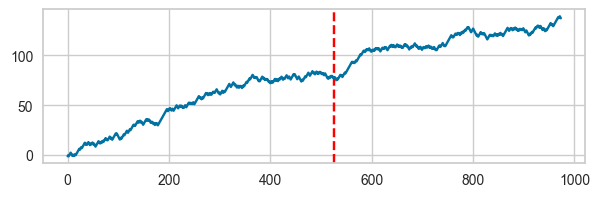

In [29]:
plt.axvline(x=len(df_comp), color='red', linestyle='--')
df_completo = info_modelo(mdl, pd.concat([treino, val1, val2]), filtro = flt)

# Comparação de modelos

### Escolhendo os modelos

DecisionTreeClassifier (i = 0)

PL: 34.80 | ROI: 4.91% | Prec.: 0.55
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.05
709 entradas em 3480 jogos (20.37%)


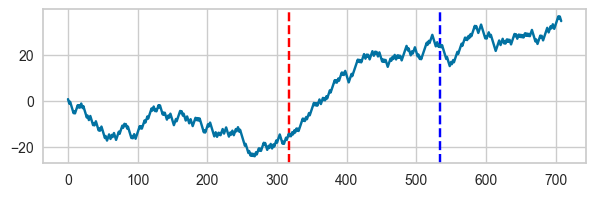

XGBClassifier (i = 1)

PL: 30.03 | ROI: 4.54% | Prec.: 0.55
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.05
662 entradas em 3480 jogos (19.02%)


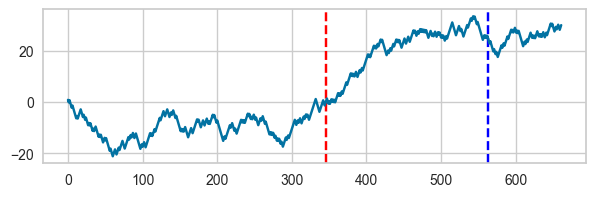

KNeighborsClassifier (i = 2)

PL: 35.73 | ROI: 5.47% | Prec.: 0.55
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.05
653 entradas em 3480 jogos (18.76%)


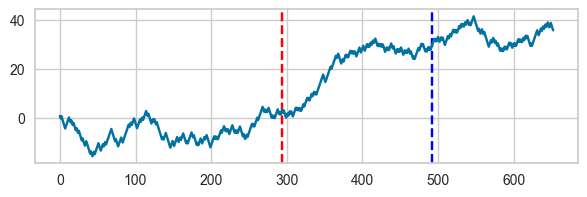

ExtraTreesClassifier (i = 3)

PL: 56.02 | ROI: 8.78% | Prec.: 0.57
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.08
638 entradas em 3480 jogos (18.33%)


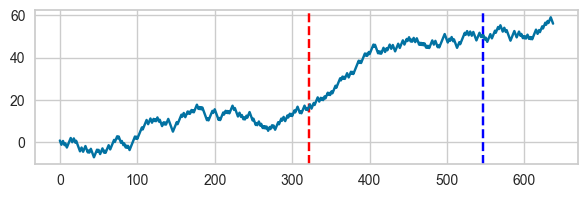

RandomForestClassifier (i = 4)

PL: 47.73 | ROI: 7.32% | Prec.: 0.56
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.06
652 entradas em 3480 jogos (18.74%)


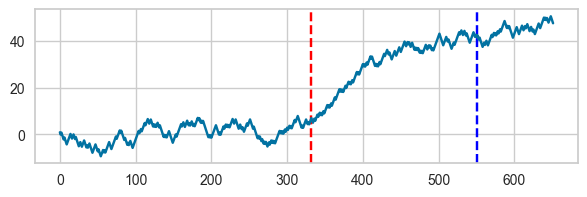

LGBMClassifier (i = 5)

PL: 53.30 | ROI: 7.45% | Prec.: 0.57
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.08
715 entradas em 3480 jogos (20.55%)


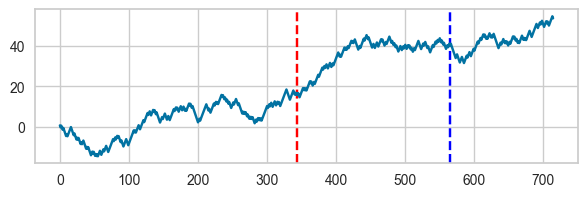

AdaBoostClassifier (i = 6)

PL: 18.16 | ROI: 2.23% | Prec.: 0.54
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.03
815 entradas em 3480 jogos (23.42%)


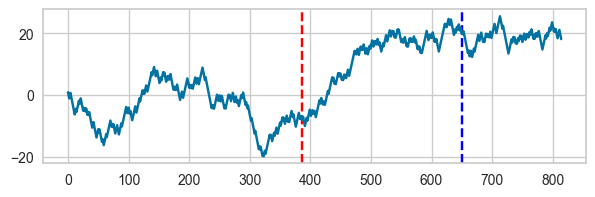

LinearDiscriminantAnalysis (i = 7)

PL: 106.14 | ROI: 13.23% | Prec.: 0.59
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.12
802 entradas em 3480 jogos (23.05%)


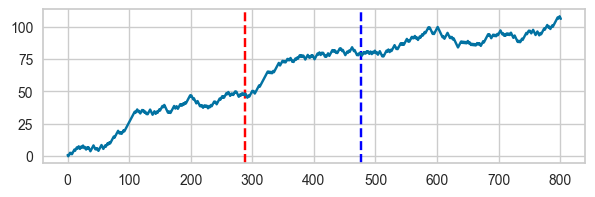

LogisticRegression (i = 8)

PL: 92.77 | ROI: 13.68% | Prec.: 0.60
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.14
678 entradas em 3480 jogos (19.48%)


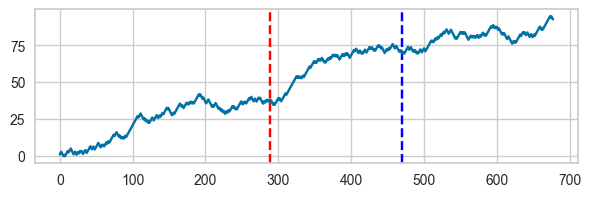

RidgeClassifier (i = 9)

PL: 106.87 | ROI: 14.36% | Prec.: 0.60
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.14
744 entradas em 3480 jogos (21.38%)


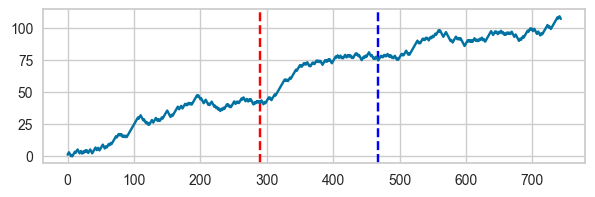

GaussianNB (i = 10)

PL: 54.05 | ROI: 9.53% | Prec.: 0.57
Odd média: 1.90 (0.53 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.09
567 entradas em 3480 jogos (16.29%)


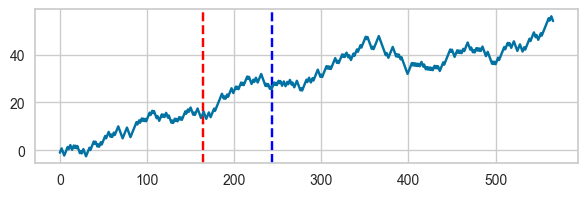

SGDClassifier (i = 11)

PL: 79.05 | ROI: 6.45% | Prec.: 0.56
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.07
1226 entradas em 3480 jogos (35.23%)


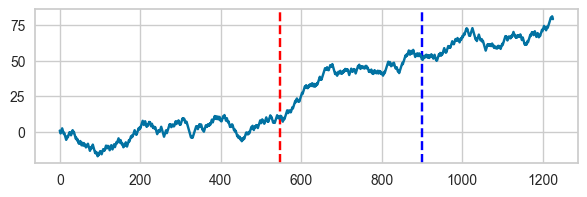

GradientBoostingClassifier (i = 12)

PL: 38.07 | ROI: 5.31% | Prec.: 0.55
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.05
717 entradas em 3480 jogos (20.60%)


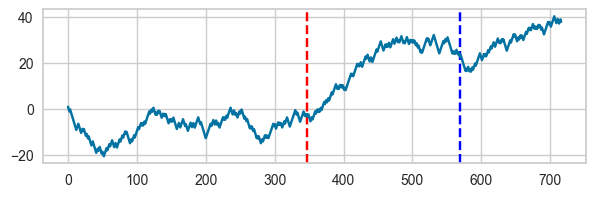

QuadraticDiscriminantAnalysis (i = 13)

O modelo apresentou um erro.



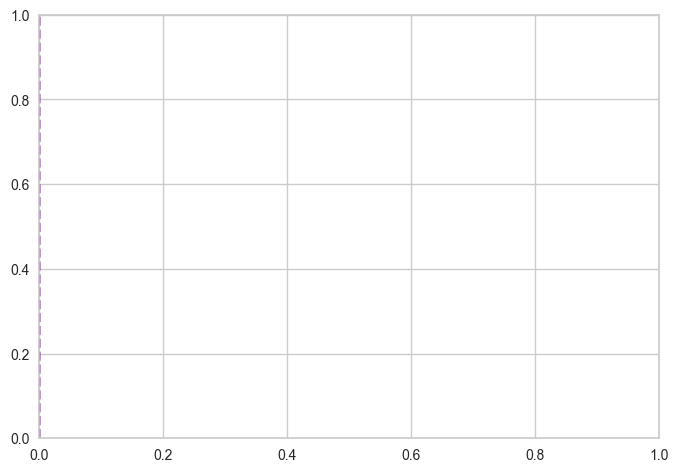

In [19]:
FILTRO = 2
CONJUNTO = 'val'

for i in range(14):
    try:
        if CONJUNTO != 'teste':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux_tr = treina_modelo(top[i], real_teste)
            aux_tr = filtra_resultados(aux_tr, filtro = FILTRO)
            plt.axvline(x=len(aux_tr), color='red', linestyle='--')
            aux_total = treina_modelo(top[i], val1)
            aux_total = filtra_resultados(aux_total, filtro = FILTRO)
            plt.axvline(x=len(aux_total) + len(aux_tr), color='blue', linestyle='--')
            aux = info_modelo(top[i], pd.concat([real_teste, val1, val2]), filtro = FILTRO)
        else:
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux = info_modelo(top[i], real_teste, filtro = FILTRO)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass

In [20]:
blended79 = blend_models(estimator_list = [top[9], top[7]], fold = 5, verbose=False)

In [21]:
model_list = [top[9], top[7], blended79]

### Resultados

RidgeClassifier

PL: 106.87 | ROI: 14.36% | Prec.: 0.60
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.14
744 entradas em 3480 jogos (21.38%)


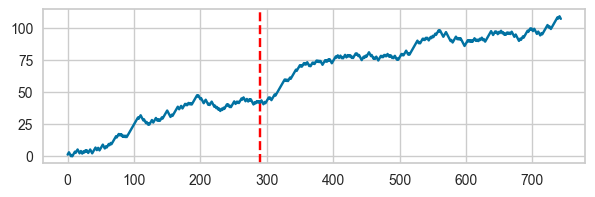

LinearDiscriminantAnalysis

PL: 106.14 | ROI: 13.23% | Prec.: 0.59
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.12
802 entradas em 3480 jogos (23.05%)


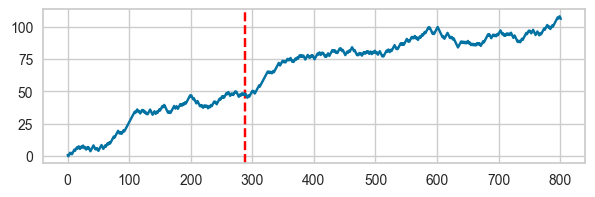

VotingClassifier

PL: 104.10 | ROI: 14.77% | Prec.: 0.60
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.14
705 entradas em 3480 jogos (20.26%)


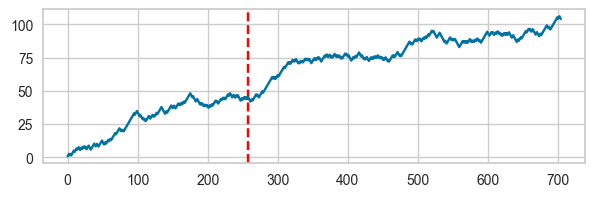

In [22]:
FILTRO = 2

for item in model_list:
    try:
        print(f'{item.__class__.__name__}\n')
        aux_total = treina_modelo(item, real_teste)
        aux_total = filtra_resultados(aux_total, filtro = FILTRO)
        plt.axvline(x=len(aux_total), color='red', linestyle='--')
        aux = info_modelo(item, pd.concat([real_teste, val]), filtro = FILTRO)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass

# Script qcut

In [136]:
# df_cut1 = df_treino.copy()
df_cut = df_comp.copy()
# df_cut = pd.concat([df_cut1, df_cut2])

In [138]:
variaveis = features.copy()
variaveis.append('prediction_score')

for var in variaveis:
    try:
        nome = f'Cat_{var}'
        # Usa qcut para definir os grupos
        df_cut[nome]  = pd.qcut(df_cut[var], q = 7, duplicates='drop')

        target = 'PL_BF_Predictions'
        pivot_table = pd.pivot_table(df_cut,
                                    values=target,
                                    index=[nome],
                                    aggfunc=['sum', 'count']
                                    )
        

        pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

        aux_treino = pivot_table[pivot_table['ratio'] != 0]


        print(var)
        print(aux_treino)
        print()
        print('\n\n')
        print('------------------------------------------------')
        print('\n\n')
    except:
        pass

Odds_H
                                        sum             count     ratio
                          PL_BF_Predictions PL_BF_Predictions          
Cat_Odds_H                                                             
(1.0190000000000001, 1.1]          7.499999               116  0.064655
(1.1, 1.16]                        7.349998               120  0.061250
(1.16, 1.26]                      17.449999               108  0.161574
(1.26, 2.7]                       36.799999               119  0.309244
(2.7, 3.343]                      14.699999               105  0.140000
(3.343, 4.5]                      -2.500001               126 -0.019841
(4.5, 10.5]                       15.799998               102  0.154902




------------------------------------------------



Odds_A
                                         sum             count     ratio
                           PL_BF_Predictions PL_BF_Predictions          
Cat_Odds_A                                                      

In [ ]:
_df = _df[((_df['CV_ML'] >= 0) & (_df['CV_ML'] < 0.65)) | ((_df['CV_ML'] >= 0.77) & (_df['CV_ML'] < 0.87)) | ((_df['CV_ML'] >= 0.95) & (_df['CV_ML'] < 1.5))]

_df = _df[((_df['P_Diff'] < 0.42) | (_df['P_Diff'] > 0.44))]


In [ ]:
# display(df_cut2.groupby('Cat_DP_Odds_Geral_H')['DP_Odds_Geral_H'].describe())

# Script variáveis

In [ ]:
colunas = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Porc_Over_Home',
       'Porc_Over_Away', 'Avg_CG_H', 'DP_CG_H',
       'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'MediaCustoGolHome',
       'MediaCustoGolAway', 'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H',
       'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML',
       'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH', 'Custo_Retorno_BH',
       'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real', 'Dist_Porc_BH',
       'Retornos_BA_Acu', 'Avg_Retornos_BA', 'Custo_Retorno_BA',
       'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real', 'Dist_Porc_BA']

colunas = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line',  'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 
       'P(O)', 'P(U)', 'P_Diff', 'CV_ML',
       'CV_Over', 'CV_HA']

In [ ]:
import random

def pegar_elementos_aleatorios(lista):
    # Gerar um número aleatório entre 2 e 7
    num_elementos = random.randint(5, 12)

    # Garantir que o número de elementos não ultrapasse o tamanho da lista
    num_elementos = min(num_elementos, len(lista))

    # Selecionar elementos aleatórios da lista
    elementos_aleatorios = random.sample(lista, num_elementos)

    return elementos_aleatorios

In [ ]:
def cria_modelo(fts, _seed = 2023, _filtro = 0):
        try:
                cria_setup(features=fts, seed = _seed)

                model = create_model('lr', verbose = False, fold = 5)
                tab = pull()
                prec_model = (tab.loc['Mean', 'Prec.'])
                previsoes = predict_model(model, verbose = False)

                stake = 1

                total = previsoes.shape[0]

                previsoes = previsoes[previsoes['prediction_label'] == 1]
                previsoes = filtra_resultados(previsoes, filtro = _filtro)

                previsoes.loc[(previsoes[TARGET] == 1), 'PL_BF_Predictions'] = (previsoes[ODDS] - 1) * stake
                previsoes.loc[(previsoes[TARGET] == 0), 'PL_BF_Predictions'] = - stake

                plb = previsoes['PL_BF_Predictions'].sum()
                entradas = previsoes.shape[0]
                wr = round((previsoes[previsoes[TARGET] == 1].shape[0] / entradas), 2)
                oddback = previsoes[previsoes['prediction_label'] == 1][ODDS].mean()
                med_gain = previsoes[previsoes[TARGET] == 1]['PL_BF_Predictions'].mean()
                med_loss = previsoes[previsoes[TARGET] == 0]['PL_BF_Predictions'].mean()
                roi = plb / entradas
                porc_ent = entradas / total
                ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

                metrics = [prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev]

                return metrics
        except Exception as e:
                print(e)
                return [0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
melhor_PL = -10000

for i in range(20):
    feats = pegar_elementos_aleatorios(colunas)
    feats.append(ODDS)

    metrics = cria_modelo(fts=feats)
    prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics
            
    print(f'Rodada {i+1}')
    if plb > melhor_PL:
        melhor_PL = plb
        print(f'**Novo melhor**')
        print(f'Precision: {prec_model:.4f}')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        print(f'features = {feats}\n')
    print()

In [ ]:
# RF
Rodada 18
**Novo melhor**
Precision: 0.3716
PL: -9.32 | ROI: -3.49% | EM: -0.03 | Prec.: 0.40 | Entradas: 0.36
features = ['HA_Line', 'Odds_Over', 'CV_ML', 'Over_Line', 'HA_Odds_H', 'HA_Odds_A', 'Odds']

Rodada 8
**Novo melhor**
Precision: 0.3534
PL: -14.00 | ROI: -5.62% | EM: -0.06 | Prec.: 0.38 | Entradas: 0.33
features = ['HA_Odds_A', 'P(H)', 'CV_Over', 'P(A)', 'P(U)', 'HA_Odds_H', 'CV_ML', 'HA_Line', 'CV_HA', 'P_Diff', 'Odds_A', 'P(O)', 'Odds']

# ADA
Rodada 4
**Novo melhor**
Precision: 0.4163
PL: -17.24 | ROI: -5.46% | EM: -0.04 | Prec.: 0.41 | Entradas: 0.42
features = ['Odds_A', 'HA_Odds_A', 'CV_ML', 'Odds_Under', 'P(O)', 'P(U)', 'Odds']

Rodada 5
**Novo melhor**
Precision: 0.4107
PL: -14.11 | ROI: -5.21% | EM: -0.05 | Prec.: 0.40 | Entradas: 0.36
features = ['CV_Over', 'P(O)', 'P(U)', 'Odds_Over', 'Over_Line', 'P(H)', 'Odds']

# KNN
Rodada 1
**Novo melhor**
Precision: 0.3814
PL: -16.90 | ROI: -4.96% | EM: -0.04 | Prec.: 0.39 | Entradas: 0.46
features = ['CV_HA', 'CV_Over', 'Odds_A', 'Over_Line', 'HA_Line', 'Odds']

Rodada 16
**Novo melhor**
Precision: 0.3689
PL: -8.03 | ROI: -2.32% | EM: -0.02 | Prec.: 0.40 | Entradas: 0.47
features = ['CV_Over', 'CV_HA', 'HA_Line', 'P(H)', 'HA_Odds_A', 'Odds']


# Segundo filtro

In [ ]:
fits = ['HA_Line', 'Odds_Over', 'CV_ML', 'Over_Line', 'HA_Odds_H', 'HA_Odds_A', 'Odds']

In [ ]:
metrics = cria_modelo(fits)
prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics

print('---------------------- BASE ----------------------')
print(f'Precision: {prec_model:.4f}')
print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
print(f'fits = {fits}\n')
print('--------------------------------------------------')
melhor_PL = plb

for i in range(len(fits) - 1):
    feat = fits[i]
    fits.pop(i)
    print(f'Removido: {feat}')

    metrics = cria_modelo(fits)
    prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics

    if plb >= melhor_PL:
        print('*** NOVO MELHOR ***')
        melhor_PL = plb
    print(f'Precision: {prec_model:.4f}')
    print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
    print(f'fits = {fits}\n')
    fits.insert(i, feat)
    print()

# Cross validation

In [30]:
results = []
seeds = random.sample(range(0, 9999), 10)

for i in range(len(seeds)):

        cria_setup(seed=seeds[i], features=features)

        cross_model = create_model('lda', verbose = False, cross_validation=False)
        
        previsoes = predict_model(cross_model, val, verbose = False)
        previsoes = previsoes.merge(df[ODDS], left_index=True, right_index=True, how='left')
        if f'{ODDS}_x' in previsoes.columns.tolist():
                previsoes.rename(columns={f'{ODDS}_x': ODDS}, inplace=True)
                previsoes.drop(columns=f'{ODDS}_y', inplace=True)

        stake = 1

        total = previsoes.shape[0]

        previsoes = previsoes[(previsoes['prediction_label'] == 1)]

        previsoes.loc[(previsoes[TARGET] == 1), 'PL_BF_Predictions'] = (previsoes[ODDS] - 1) * stake
        previsoes.loc[(previsoes[TARGET] == 0), 'PL_BF_Predictions'] = - stake

        ############ Filtro ############
        previsoes = filtra_resultados(previsoes, filtro = 0)
        previsoes = calcula_profit(previsoes)
        metrics = exibe_metricas(previsoes, total = total, return_metrics=True)
        plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics
        
        results.append(wr)

        print(f'Fold {i+1} (seed {seeds[i]})')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        print()

print(f'Média: {np.mean(results):.2f} | DP: {np.std(results):.2f}')

Fold 1 (seed 1941)
PL: 37.04 | ROI: 8.88% | EM: 0.08 | Prec.: 0.57 | Entradas: 0.22

Fold 2 (seed 2100)
PL: 38.77 | ROI: 8.77% | EM: 0.08 | Prec.: 0.57 | Entradas: 0.23

Fold 3 (seed 4121)
PL: 35.64 | ROI: 7.02% | EM: 0.06 | Prec.: 0.56 | Entradas: 0.27

Fold 4 (seed 5139)
PL: 28.76 | ROI: 5.28% | EM: 0.04 | Prec.: 0.55 | Entradas: 0.29

Fold 5 (seed 7439)
PL: 20.55 | ROI: 5.24% | EM: 0.05 | Prec.: 0.55 | Entradas: 0.21

Fold 6 (seed 4389)
PL: 84.28 | ROI: 6.71% | EM: 0.07 | Prec.: 0.56 | Entradas: 0.66

Fold 7 (seed 2861)
PL: 61.41 | ROI: 4.61% | EM: 0.05 | Prec.: 0.55 | Entradas: 0.70

Fold 8 (seed 7005)
PL: 11.40 | ROI: 2.30% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.26

Fold 9 (seed 5293)
PL: 37.07 | ROI: 10.30% | EM: 0.10 | Prec.: 0.58 | Entradas: 0.19

Fold 10 (seed 2670)
PL: 67.12 | ROI: 5.33% | EM: 0.05 | Prec.: 0.55 | Entradas: 0.66

Média: 0.56 | DP: 0.01


# Entradas Aleatórias

In [18]:
def new_random_model(_val, _n):

    for i in range(_n):
        random_df = _val.copy()
        random_df['Entrada'] = [random.choice([0, 1]) for _ in range(len(random_df))]

        random_df = random_df[random_df['Entrada'] == 1]
        random_df.loc[(random_df[TARGET] == 1), 'PL'] = (random_df[ODDS] - 1)
        random_df.loc[(random_df[TARGET] == 0), 'PL'] = - 1
        
        random_df.sort_values('Date', inplace=True)
        random_df.reset_index(drop=True, inplace=True)
        random_df['hbacu'] = random_df['PL'].cumsum()
        random_df['hbacu'].plot.line(figsize=(12,6))
    
    plt.show()

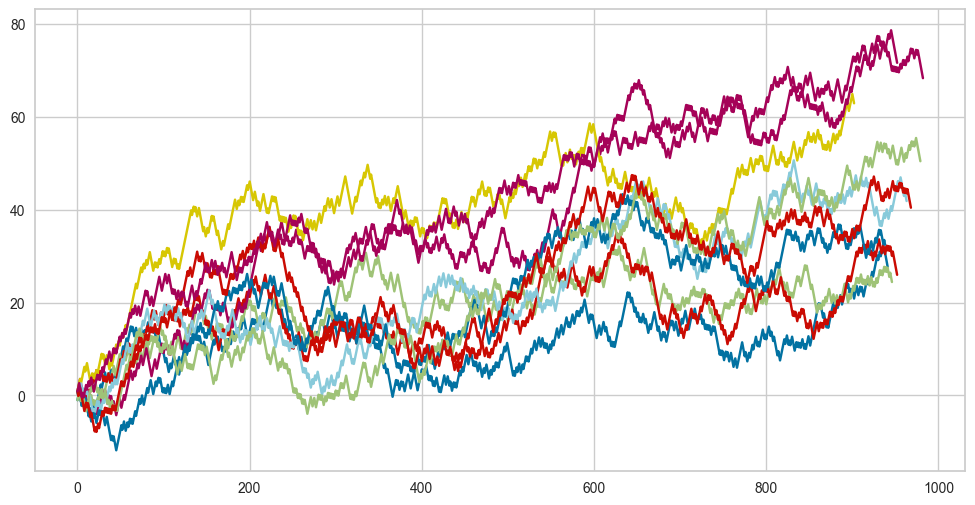

In [20]:
new_random_model(val, 10)